# Parameter Inference With Bioscrape

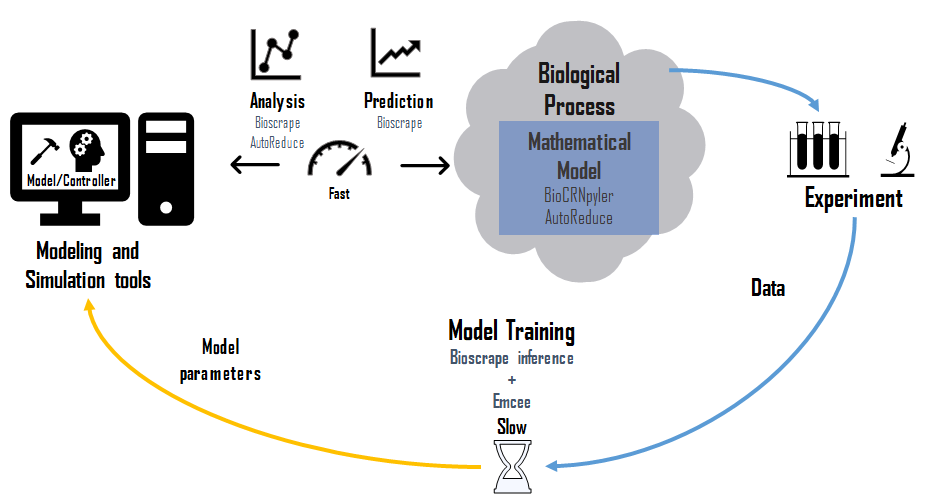

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from cycler import cycler
import numpy as np
import bioscrape as bs

sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 1.5})
sns.set_style("ticks")
sns.set_style({"xtick.direction": "in","ytick.direction": "in"})

#%config InlineBackend.figure_f.ormats=['svg']

mpl.rc('axes', prop_cycle=(cycler('color', ['r', 'k', 'b','g','y','m','c']) ))

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

#mpl.rc('text', usetex=False)
#mpl.rc('text.latex', preamble=r'\usepackage{helvet}
#\renewcommand\familydefault{\sfdefault}\usepackage{sansmath}\sansmath')
# mpl.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica Neue'], 
#                  'serif': ['Helvetica Neue']})

mpl.rcParams['font.family'] = 'Helvetica'

tw = 1.5

sns.set_style({"xtick.major.size": 3, "ytick.major.size": 3,
               "xtick.minor.size": 2, "ytick.minor.size": 2,
               'axes.labelsize': 16, 'axes.titlesize': 16,
               'xtick.major.width': tw, 'xtick.minor.width': tw,
               'ytick.major.width': tw, 'ytick.minor.width': tw})

mpl.rc('xtick', labelsize=14) 
mpl.rc('ytick', labelsize=14)
mpl.rc('axes', linewidth=1.5, titlesize=14, labelsize=14)
mpl.rc('legend', fontsize=14)
mpl.rc('figure', figsize=(8.5,15))

## Load data and create dataframe

To get started with parameter identification, we load the data file from Github:

## Pre-process the CSV from Echo or Biotek

In [ ]:
import pandas as pd
import numpy as np

def time_in_minutes(t):
    ans = t.hour*60+t.minute+t.second/60.0+t.microsecond / 1000000.0 / 60.0
    if type(t).__name__ == 'datetime':
        ans += t.day * 24*60
    return ans
        
csv_data = pd.read_csv('20220425_2D_Dilution_Int_Reporter_Biotek1_tidy.csv')
# csv_data = pd.read_csv('20220609_2D_Int_Rep_Triplicate_Test_Biotek1_tidy.csv')

# cfp = cfp[:, 2:]
# yfp = yfp[:, 2:]

# Data arrays:
num_integrase_conditions = 5
num_reporter_conditions = 5
num_replicates = 2
biotek_gain = 100

# All time points are the same, so just get one set of times for a given condition and measurement
chosen_well = np.array(csv_data.loc[(csv_data['Channel'].eq('YFP'))& (csv_data['Int (nM)'].eq(1))\
                       & (csv_data['Rep (nM)'].eq(1))\
                       & (csv_data['Gain'].eq(biotek_gain))]['Well'])[0]
timepoints = np.array(csv_data.loc[(csv_data['Channel'].eq('YFP'))& (csv_data['Int (nM)'].eq(1))\
                       & (csv_data['Rep (nM)'].eq(1))\
                       & (csv_data['Gain'].eq(biotek_gain)) & (csv_data['Well'].eq(chosen_well))]['Time (hr)']*60)
real_timepoints = timepoints

num_timepoints = np.shape(timepoints)[0]
full_cfp = np.empty( (num_timepoints, num_replicates , num_integrase_conditions , num_reporter_conditions ) )
full_yfp = np.empty( (num_timepoints, num_replicates , num_integrase_conditions , num_reporter_conditions ) )

back_cfp = np.empty( (num_timepoints, num_replicates , num_integrase_conditions , num_reporter_conditions ) )
back_yfp = np.empty( (num_timepoints, num_replicates , num_integrase_conditions , num_reporter_conditions ) )

int_conditions = [0, 0.25, 0.5, 0.75, 1]
rep_conditions = [0, 0.25, 0.5, 0.75, 1]

for int_nm,int_ind in zip(int_conditions,range(num_integrase_conditions)):
    for rep_nm,rep_ind in zip(rep_conditions,range(num_reporter_conditions)):
        for repl in range(num_replicates):
            replicate = repl+1
            full_cfp[:,repl,int_ind,rep_ind] = np.array(csv_data.loc[(csv_data['Channel'].eq('deCFP'))\
                                                                   & (csv_data['Int (nM)'].eq(int_nm))\
                                                                   & (csv_data['Rep (nM)'].eq(rep_nm))\
                                                                   & (csv_data['Gain'].eq(biotek_gain))\
                                                                   & (csv_data['Replicate'].eq(replicate))\
                                                                   & (csv_data['deGFP Positive Control (nM)'].eq(0))]\
                                                      ['Measurement'])# calibration factors / 13809. * 1000.0
            back_cfp[:,repl,int_ind,rep_ind] = np.array(csv_data.loc[(csv_data['Channel'].eq('deCFP'))\
                                                                   & (csv_data['Int (nM)'].eq(0))\
                                                                   & (csv_data['Rep (nM)'].eq(rep_nm))\
                                                                   & (csv_data['Gain'].eq(biotek_gain))\
                                                                   & (csv_data['Replicate'].eq(replicate))\
                                                                   & (csv_data['deGFP Positive Control (nM)'].eq(0))]\
                                                      ['Measurement'])# calibration factors / 13809. * 1000.0
            full_yfp[:,repl,int_ind,rep_ind] = np.array(csv_data.loc[(csv_data['Channel'].eq('YFP'))\
                                                                   & (csv_data['Int (nM)'].eq(int_nm))\
                                                                   & (csv_data['Rep (nM)'].eq(rep_nm))\
                                                                   & (csv_data['Gain'].eq(biotek_gain))\
                                                                   & (csv_data['Replicate'].eq(replicate))\
                                                                   & (csv_data['deGFP Positive Control (nM)'].eq(0))]\
                                                      ['Measurement']) # calibration factors / 50405. * 1000.0
            back_yfp[:,repl,int_ind,rep_ind] = np.array(csv_data.loc[(csv_data['Channel'].eq('YFP'))\
                                                                   & (csv_data['Int (nM)'].eq(int_nm))\
                                                                   & (csv_data['Rep (nM)'].eq(0))\
                                                                   & (csv_data['Gain'].eq(biotek_gain))\
                                                                   & (csv_data['Replicate'].eq(replicate))\
                                                                   & (csv_data['deGFP Positive Control (nM)'].eq(0))]\
                                                      ['Measurement']) # calibration factors / 50405. * 1000.0


# Calibrate to concentration (using: https://biocircuits.cds.caltech.edu/TXTL-calibration#Biotek_Calibration_4/22/2022_Makena)
# Linear fit: RFU measurement = slope*concentration in uM + intercept
# So, concentration (in nM) = 1000*(RFU - intercept)/slope
if biotek_gain == 61:
    cfp_slope = 456.71
#     cfp_intercept = -384.26
    cfp_intercept = 0
    yfp_slope = 993.69
#     yfp_intercept = 468.56
    yfp_intercept = 0

if biotek_gain == 100:
    cfp_slope = 12796.23
    cfp_intercept = -6248.64 
#     cfp_intercept = 0
    yfp_slope = 44451.55
#     yfp_intercept = 294
    yfp_intercept = 0

for int_nm,int_ind in zip(int_conditions,range(num_integrase_conditions)):
    for rep_nm,rep_ind in zip(rep_conditions,range(num_reporter_conditions)):
        for repl in range(num_replicates):
            full_cfp[:,repl,int_ind,rep_ind] = 1000*(1/cfp_slope)*(full_cfp[:,repl,int_ind,rep_ind] - cfp_intercept)
            back_cfp[:,repl,int_ind,rep_ind] = 1000*(1/cfp_slope)*(back_cfp[:,repl,int_ind,rep_ind] - cfp_intercept)
            full_yfp[:,repl,int_ind,rep_ind] = 1000*(1/yfp_slope)*(full_yfp[:,repl,int_ind,rep_ind] - yfp_intercept)
            back_yfp[:,repl,int_ind,rep_ind] = 1000*(1/yfp_slope)*(back_yfp[:,repl,int_ind,rep_ind] - yfp_intercept)
#Process the background.
for rep_ind in range(num_reporter_conditions):
    for int_ind in range(num_integrase_conditions):
        full_cfp[:,:,int_ind,rep_ind] = np.maximum(full_cfp[:,:,int_ind,rep_ind] - back_cfp[:,:,int_ind,rep_ind], 0)
        full_yfp[:,:,int_ind,rep_ind] = np.maximum(full_yfp[:,:,int_ind,rep_ind] - back_yfp[:,:,int_ind,rep_ind], 0)

# cfp_bg = np.empty(num_timepoints)
# for t in range(len(cfp_bg)):
#     cfp_bg[t] = np.median(full_cfp[t,:,0,:])

# for rep_ind in range(num_reporter_conditions):
#     for int_ind in range(num_integrase_conditions):
#         for repl in range(num_replicates):
#             temp = full_cfp[:,repl,int_ind,:] - full_cfp[:,repl,0,:]
#             full_cfp[:,repl,int_ind,:] = np.maximum(temp,0)
###
# for rep_ind in range(num_reporter_conditions):
#     for int_ind in range(num_integrase_conditions):
#         if int_ind == 0:
#             continue
#         else:
#             full_cfp[:,:,int_ind,rep_ind] = np.maximum(full_cfp[:,:,int_ind,rep_ind] - full_cfp[:,:,0,rep_ind], 0)

# Set CFP to zero when 0 DNA was added (this background/noise was subtracted from the data above)
# full_cfp[:,:,0,:] = np.zeros((len(timepoints), num_replicates, num_reporter_conditions))

# #Process the YFP background.
# yfp_bg = np.empty(num_timepoints)
# for t in range(len(yfp_bg)):
#     yfp_bg[t] = np.median(full_yfp[t,:,:,0])

# for int_ind in range(num_integrase_conditions):
#     for rep_ind in range(num_reporter_conditions):
#         for repl in range(num_replicates):
#             temp = full_yfp[:,repl,int_ind,rep_ind] - full_yfp[:,repl,int_ind,0]
#             full_yfp[:,repl,int_ind,rep_ind] = np.maximum(temp,0)
            
# for int_ind in range(num_reporter_conditions):
#     for rep_ind in range(num_integrase_conditions):
#         if rep_ind == 0:
#             continue
#         else:
#             full_yfp[:,:,int_ind,rep_ind] = np.maximum(full_yfp[:,:,int_ind,rep_ind] - full_yfp[:,:,int_ind,0], 0)

# # Set YFP to zero when 0 DNA was added (this background/noise was subtracted from the data above)
# full_yfp[:,:,:,0] = np.zeros((len(timepoints), num_replicates, num_integrase_conditions))

## Plot experimental data

In [ ]:
figsize = (10,8)
figc = plt.figure(figsize=figsize)
# figy = plt.figure(figsize=figsize)

current_index = 1


cfp_median = np.empty((num_timepoints,num_integrase_conditions,num_reporter_conditions))
yfp_median = np.empty((num_timepoints,num_integrase_conditions,num_reporter_conditions))

for int_ind in range(num_integrase_conditions):
    for rep_ind in range(num_reporter_conditions):
        cfp_median[:,int_ind,rep_ind] = np.mean(full_cfp[:,:,int_ind, rep_ind],axis=1)
        axc = figc.add_subplot(num_integrase_conditions,num_reporter_conditions,current_index)
        axc.plot(timepoints,cfp_median[:,int_ind,rep_ind], 'b-')
        axc.plot(timepoints,full_cfp[:,:,int_ind, rep_ind], 'b.', markersize=4)
        for tl in axc.get_yticklabels():
            tl.set_color('b')
        
        axy = axc.twinx()
        yfp_median[:,int_ind,rep_ind] = np.mean(full_yfp[:,:,int_ind, rep_ind],axis=1)
        axy.plot(timepoints, yfp_median[:,int_ind,rep_ind], 'g-')
        axy.plot(timepoints, full_yfp[:,:,int_ind,rep_ind], 'g.', markersize=4)
        for tl in axy.get_yticklabels():
            tl.set_color('g')
        
        
#         axy = figy.add_subplot(5,5,current_index)
#         yfp_median[:,int_nm,rep_nm] = np.median(full_yfp[:,:,int_nm, rep_nm],axis=1)
#         axy.plot(timepoints, yfp_median[:,int_nm,rep_nm], 'g-')
#         axy.plot(timepoints, full_yfp[:,:,int_nm,rep_nm], 'g.', markersize=4)
#         axy.set_xlim(time_lim)
#         axy.set_ylim(yfp_lim)
        
        if rep_ind > 0:
            axc.set_yticklabels([])
        if rep_ind < num_reporter_conditions - 1:
            axy.set_yticklabels([])
        if int_ind < num_integrase_conditions - 1:
            axy.set_xticklabels([])
        
        if int_ind == num_integrase_conditions - 1 and rep_ind ==  num_reporter_conditions//2:
            axc.set_xlabel('Time (min)',labelpad=20)
#             axy.set_xlabel('Time (min)')
        if rep_ind == 0 and int_ind ==  num_integrase_conditions//2:
#             axy.set_ylabel('Venus YFP (nm)')
            axc.set_ylabel('CFP (nM)',color='b',labelpad=20)
        if rep_ind ==  num_reporter_conditions - 1 and int_ind ==  num_integrase_conditions//2:
            axy.set_ylabel('YFP (nM)', color='g',labelpad=20)
        current_index += 1

figc.tight_layout()
# figy.tight_layout()


In [ ]:
initial_conditions = []
all_data = []
expdata_dict = {}
for int_ind, int_nm in zip(range(num_integrase_conditions), int_conditions):
    for rep_ind, rep_nm in zip(range(num_reporter_conditions),rep_conditions):
        initial_conditions.append({"G_I": int_nm, "G_tot": rep_nm})
        expdata_dict[(int_nm,rep_nm,'CFP')] = cfp_median[:,int_ind,rep_ind]
        expdata_dict[(int_nm,rep_nm,'YFP')] = yfp_median[:,int_ind,rep_ind]
        all_data.append(expdata_dict)

In [ ]:
timepoints[:180][-1]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
colorc = ['#9ecae1','#6baed6','#4292c6', '#2171b5','#084594']
colory = ['#a1d99b','#74c476','#41ab5d','#238b45','#005a32']
time_lim = (0,timepoints[-1]+1)
# timepoints = np.linspace(0,time_lim[1],49)
cfp_lim = (0,65)
yfp_lim = (0,200)
figsize = (18,8)
fig = plt.figure(figsize=figsize)
index = 1
for rep_ind in range(num_reporter_conditions):
    if index == 1:
        axc = fig.add_subplot(2,num_integrase_conditions,index)
        axy = fig.add_subplot(2,num_reporter_conditions,index+5)
    else:
        axc = fig.add_subplot(2,num_integrase_conditions,index, sharey = axc)
        axy = fig.add_subplot(2,num_reporter_conditions,index+5, sharey = axy)
    
    for int_ind in range(num_integrase_conditions):
        axc.plot(timepoints, expdata_dict[(int_conditions[int_ind] ,rep_conditions[rep_ind],'CFP')],
                 color=colorc[int_ind] )
        axy.plot(timepoints, expdata_dict[(int_conditions[int_ind] ,rep_conditions[rep_ind],'YFP')]
                 ,color=colory[int_ind])
    
    axc.set_title('%1.2f nM reporter' % (rep_conditions[rep_ind]))
    axc.set_xlim(time_lim)
    axy.set_xlim(time_lim)
#     axc.set_ylim(cfp_lim)
#     axy.set_ylim(yfp_lim)

    axy.set_xlabel('Time (min)')
    
    if index == 1:
        axc.set_ylabel('CFP (nM)')
        axy.set_ylabel('YFP (nM)')
        axc.legend(['0 nM int. plasmid', '0.25 nM int. plasmid',
                    '0.50 nM int. plasmid', '0.75 nM int. plasmid',
                    '1.00 nM int. plasmid'],
                   loc='best',bbox_to_anchor=(7.61, 1), fontsize = 14)
        axy.legend(['0 nM int. plasmid', '0.25 nM int. plasmid',
                    '0.50 nM int. plasmid', '0.75 nM int. plasmid',
                    '1.00 nM int. plasmid'],
                   loc='best',bbox_to_anchor=(7.61, 1), fontsize = 14)
#     else:
#         axc.set_yticks([])
#         axy.set_yticks([])
    axc.set_xticks([])

    index += 1

fig.tight_layout()
# fig.savefig('integrase-raw-data.svg')

## Truncate data to 600 minutes:

We truncate the experimental data to 600 minutes as that is the time-period of interest and our model does not capture the leveling out of the fluorescence reporter amounts.

In [ ]:
initial_conditions = []
all_data = []
expdata_dict = {}
timepoints = real_timepoints[:120]
for int_ind, int_nm in zip(range(num_integrase_conditions), int_conditions):
    for rep_ind, rep_nm in zip(range(num_reporter_conditions),rep_conditions):
        initial_conditions.append({"G_I": int_nm, "G_tot": rep_nm})
        expdata_dict[(int_nm,rep_nm,'CFP')] = cfp_median[:120,int_ind,rep_ind]
        expdata_dict[(int_nm,rep_nm,'YFP')] = yfp_median[:120,int_ind,rep_ind]
        all_data.append(expdata_dict)

colorc = ['#9ecae1','#6baed6','#4292c6', '#2171b5','#084594']
colory = ['#a1d99b','#74c476','#41ab5d','#238b45','#005a32']
# time_lim = (0,timepoints[-1]+1)
# timepoints = np.linspace(0,time_lim[1],49)
# cfp_lim = (0,65)
# yfp_lim = (0,200)
plt.close()
figsize = (16,8)
fig = plt.figure(figsize=figsize)
index = 1
for rep_ind in range(num_reporter_conditions):
    if index == 1:
        axc = fig.add_subplot(2,num_integrase_conditions,index)
        axy = fig.add_subplot(2,num_reporter_conditions,index+5)
    else:
        axc = fig.add_subplot(2,num_integrase_conditions,index, sharey = axc)
        axy = fig.add_subplot(2,num_reporter_conditions,index+5, sharey = axy)
        
    for int_ind in range(num_integrase_conditions):
        axc.plot(timepoints, expdata_dict[(int_conditions[int_ind] ,rep_conditions[rep_ind],'CFP')],
                 color=colorc[int_ind] )
        axy.plot(timepoints, expdata_dict[(int_conditions[int_ind] ,rep_conditions[rep_ind],'YFP')]
                 ,color=colory[int_ind])
    
    axc.set_title('%1.2f nM reporter' % (rep_conditions[rep_ind]))
#     axc.set_xlim(time_lim)
#     axy.set_xlim(time_lim)
#     axc.set_ylim(cfp_lim)
#     axy.set_ylim(yfp_lim)

    axy.set_xlabel('Time (min)')
    
    if index == 1:
        axc.set_ylabel('CFP (nM)')
        axy.set_ylabel('YFP (nM)')
        axc.legend(['0 nM int. plasmid', '0.25 nM int. plasmid',
                    '0.50 nM int. plasmid', '0.75 nM int. plasmid',
                    '1.00 nM int. plasmid'],
                   loc='best',bbox_to_anchor=(7.61, 1), fontsize = 14)
        axy.legend(['0 nM int. plasmid', '0.25 nM int. plasmid',
                    '0.50 nM int. plasmid', '0.75 nM int. plasmid',
                    '1.00 nM int. plasmid'],
                   loc='best',bbox_to_anchor=(7.61, 1), fontsize = 14)
#     else:
#         axc.set_yticks([])
#         axy.set_yticks([])
#     axc.set_xticks([])

    index += 1

fig.tight_layout()
fig.savefig('integrase-data-processed.svg')

# Run bioscrape inference

To identify parameter distributions, we run bioscrape inference for the example above. The three main ingredients of this black-box parameter inference pipeline are:

1. Experimental data as a `Pandas` dataframe (or a list of Dataframes) consisting of the measurements as columns along with a "time" column.
2. An SBML file that models the system we want to identify.
3. Prior information about parameters. 

We already have the experimental data as a list of Pandas dataframe above corresponding to a list of initial conditions. So, for the second step, we load the SBML file of the reduced model below:

In [ ]:
from bioscrape.inference import py_inference
from bioscrape.types import Model
from bioscrape.simulator import *
import numpy as np
import pickle
import time

# time_lim = (0,600)
int_levels = [0,0.25,0.5,0.75,1.]
rep_levels = [0,0.25,0.5,0.75,1.]
m = Model(sbml_filename = 'integrase_sbml_reduced.xml')
csim = ModelCSimInterface(m)
c_ind = m.get_species_index('Int')
y_ind = m.get_species_index('YFP')

# timepoints = np.linspace(0,time_lim[1],601)
csim.py_prep_deterministic_simulation()

propagator = DeterministicSimulator()

simdata = {}
m.set_params({'k_i': 0.24, 'k_int': 0.05, 'K_I': 3335.0, 'k': 0.05})
for int_nm in int_levels:
    for rep_nm in rep_levels:
        m.set_species({"G_I": int_nm, "G_tot": rep_nm})
        deterministic = propagator.py_simulate(csim, timepoints)
        simdata[(int_nm,rep_nm,'cfp')] = deterministic.py_get_result()[:,c_ind]
        simdata[(int_nm,rep_nm,'yfp')] = deterministic.py_get_result()[:,y_ind]

In [ ]:
colorc = ['#9ecae1','#6baed6','#4292c6', '#2171b5','#084594']
colory = ['#a1d99b','#74c476','#41ab5d','#238b45','#005a32']
time_lim = [timepoints[0], timepoints[-1]]
cfp_lim = [0, 155]
yfp_lim = [0, 155]
figsize = (16,8)
fig = plt.figure(figsize=figsize)
index = 1
for rep_ind in range(num_reporter_conditions):
    if index == 1:
        axc = fig.add_subplot(2,num_integrase_conditions,index)
        axy = fig.add_subplot(2,num_reporter_conditions,index+5)
    else:
        axc = fig.add_subplot(2,num_integrase_conditions,index, sharey = axc)
        axy = fig.add_subplot(2,num_reporter_conditions,index+5, sharey = axy)
        
    for int_ind in range(num_integrase_conditions):
        # Data
        axc.plot(timepoints, expdata_dict[(int_conditions[int_ind] ,rep_conditions[rep_ind],'CFP')],
                 color=colorc[int_ind], ls = 'dotted')
        axy.plot(timepoints, expdata_dict[(int_conditions[int_ind] ,rep_conditions[rep_ind],'YFP')]
                 ,color=colory[int_ind], ls = 'dotted')
        # Simulations
#         axc.plot(timepoints, simdata[(int_levels[int_ind] ,rep_levels[rep_ind],'cfp')],
#                  color=colorc[int_ind] )
#         axy.plot(timepoints, simdata[(int_levels[int_ind] ,rep_levels[rep_ind],'yfp')]
#                  ,color=colory[int_ind])
    
    axc.set_title('%1.2f nM reporter' % (rep_conditions[rep_ind]))
    axc.set_xlim(time_lim)
    axy.set_xlim(time_lim)
    axc.set_ylim(cfp_lim)
    axy.set_ylim(yfp_lim)

    axy.set_xlabel('Time (min)')
    
    if index == 1:
        axc.set_ylabel('CFP (nM)')
        axy.set_ylabel('YFP (nM)')
        axc.legend(['0 nM int. plasmid', '0.25 nM int. plasmid',
                    '0.50 nM int. plasmid', '0.75 nM int. plasmid',
                    '1.00 nM int. plasmid'],
                   loc='best',bbox_to_anchor=(7.61, 1), fontsize = 14)
        axy.legend(['0 nM int. plasmid', '0.25 nM int. plasmid',
                    '0.50 nM int. plasmid', '0.75 nM int. plasmid',
                    '1.00 nM int. plasmid'],
                   loc='best',bbox_to_anchor=(7.61, 1), fontsize = 14)
#     else:
#         axc.set_yticks([])
#         axy.set_yticks([])
#     axc.set_xticks([])

    index += 1

fig.tight_layout()


In [ ]:
m.get_parameter_dictionary()

In [ ]:
# Create a data frame with all the simulated and real results to use here
# as the source for doing parameter inference on the data (simulated or real)
# Columns are string for real or simulated, time, cfp, yfp, int_nm, rep_nm

import pandas as pd
e_df = {'type':[], 'time':[], 'int_nm':[], 'rep_nm':[], 'Int':[], 'YFP':[]}

# add the simulated data
for int_ind, int_nm in zip(range(num_integrase_conditions), int_conditions):
    for rep_ind, rep_nm in zip(range(num_reporter_conditions),rep_conditions):
#         timepoints = np.linspace(0,time_lim[1],241)
        length = len(timepoints)
        e_df['time'].extend(timepoints)
        e_df['type'].extend(['sim']*length)
        e_df['int_nm'].extend([int_nm]*length)
        e_df['rep_nm'].extend([rep_nm]*length)
        e_df['Int'].extend(simdata[(int_nm,rep_nm,'cfp')])
        e_df['YFP'].extend(simdata[(int_nm,rep_nm,'yfp')])

# add the real data
for int_ind, int_nm in zip(range(num_integrase_conditions), int_conditions):
    for rep_ind, rep_nm in zip(range(num_reporter_conditions),rep_conditions):
#         timepoints = real_timepoints[:49]
        length = len(timepoints)
        e_df['time'].extend(timepoints)
        e_df['type'].extend(['exp']*length)
        e_df['int_nm'].extend([int_nm]*length)
        e_df['rep_nm'].extend([rep_nm]*length)
        e_df['Int'].extend(expdata_dict[(int_nm,rep_nm,'CFP')])
        e_df['YFP'].extend(expdata_dict[(int_nm,rep_nm,'YFP')])

e_df = pd.DataFrame(e_df)

data_file = open('trace_data_frame.b','wb')
pickle.dump(e_df, data_file)
data_file.close()

In [ ]:
initial_conditions = []
all_data = []
int_levels = [0.0,0.25,0.5,0.75,1.]
rep_levels = [0.0,0.25,0.5,0.75,1.]
# int_levels = [0.5]
# rep_levels = [0.0]
# int_levels = [1.]
# rep_levels = [1.]
for int_nm in int_levels:
    for rep_nm in rep_levels:
        initial_conditions.append({"G_I": int_nm, "G_tot": rep_nm})
        exp_data = e_df.loc[(e_df['int_nm'].eq(int_nm)) & (e_df['rep_nm'].eq(rep_nm)) & (e_df['type'] == 'exp')]
        all_data.append(exp_data)

In [ ]:
# m.set_params({'k_i': 0.24, 'k_int': 0.05, 'K_I': 3335.0, 'n': 1.0, 'k': 0.05})

In [ ]:
m.get_parameter_dictionary()

In [ ]:
initial_conditions

In [ ]:
len(all_data[0]['Int'])

In [ ]:
m.get_species_dictionary()

## Run parameter inference (step 1):


In [ ]:
from bioscrape.inference import py_inference

init_values = np.array([0.23])

prior = {'k_i' : ['gaussian', 0.23, 1, 'positive']}

nwalkers = 10
nsteps = 1000
sampler, pid = py_inference(Model = m, exp_data = all_data, measurements = ['Int'], time_column = ['time'],
                            nwalkers = nwalkers, nsteps = nsteps, sim_type = 'deterministic', 
                            initial_conditions = initial_conditions, 
                            init_seed = init_values,
                            params_to_estimate = [p for p in prior],
                            prior = prior, convergence_check = False, debug = False)

In [ ]:
import corner
labels = ['$k_{i}$']
flat_samples = sampler.get_chain(discard=int(.2*nsteps), thin = int(0.5*nwalkers), flat=True)
fig = corner.corner(flat_samples, levels = (0.75,), 
                    labels = labels, use_math_text = False, 
                    label_kwargs = {'fontsize':18})
fig.savefig('mcmc_cfp_corner.svg')

In [ ]:
fig, ax = plt.subplots(figsize = (4,3))
samples = sampler.get_chain()[:,:,0]
ax.plot(samples, alpha = 0.3, color = 'k')
# ax.set_xlim(0, len(samples))
ax.set_xlabel('Steps', fontsize = 16)
ax.set_ylabel('$k_i$', fontsize = 16)
ax.set_xlim([0,nsteps])
fig.tight_layout()
fig.savefig('mcmc_cfp_chain.svg')

In [ ]:
k_i, k_i_error = pid.plot_mcmc_results(sampler)

In [ ]:
k_i

In [ ]:
m = Model(sbml_filename = 'integrase_sbml_reduced.xml')

In [ ]:
# m.set_parameter('k_i', k_i[0])
m.set_parameter('k_i', 0.2680175639510619)

In [ ]:
m.get_parameter_dictionary()

In [ ]:
m.get_species_dictionary()

In [ ]:
initial_conditions = []
all_data = []
int_levels = [0.0,0.25,0.5,0.75,1.]
rep_levels = [0.0,0.25,0.5,0.75,1.]
# int_levels = [0.5]
# rep_levels = [0.0]
# int_levels = [1.]
# rep_levels = [1.]
for int_nm in int_levels:
    for rep_nm in rep_levels:
        initial_conditions.append({"G_I": int_nm, "G_tot": rep_nm})
        exp_data = e_df.loc[(e_df['int_nm'].eq(int_nm)) & (e_df['rep_nm'].eq(rep_nm)) & (e_df['type'] == 'exp')]
        all_data.append(exp_data)

In [ ]:
initial_conditions

In [ ]:
from bioscrape.inference import py_inference

init_values = np.array([0.05,3335,2,0.05])

prior = {'k_int' : ['gaussian', 0.05, 10, 'positive'],
         'K_I' : ['gaussian', 3330, 1000, 'positive'], 'n' : ['gaussian', 2, 2, 'positive'],
         'k' : ['gaussian', 1e-4, 0.1, 'positive']}
nwalkers = 40
nsteps = 10000
sampler, pid = py_inference(Model = m, exp_data = all_data, measurements = ['YFP'], time_column = ['time'],
                            nwalkers = nwalkers, nsteps = nsteps, sim_type = 'deterministic', 
                            initial_conditions = initial_conditions, 
                            init_seed = init_values,
                            params_to_estimate = [p for p in prior],
                            prior = prior, convergence_check = False, debug = False)
# pid = py_inference(Model = m, exp_data = all_data, measurements = ['Int'], time_column = ['time'],
#                     nwalkers = nwalkers, nsteps = nsteps, sim_type = 'deterministic', 
#                     initial_conditions = initial_conditions, 
#                     init_seed = init_values,
#                     params_to_estimate = [p for p in prior],
#                     prior = prior, inference_type = "lmfit")

In [ ]:
plt.plot(pid.cost_progress)

In [ ]:
import corner
labels = ['$k_{int}$', '$K_{I}$', '$n$', '$k$']
flat_samples = sampler.get_chain(discard=int(.2*nsteps), thin = int(0.5*nwalkers), flat=True)
fig = corner.corner(flat_samples, levels = (0.75,), 
                    labels = labels, use_math_text = False, 
                    label_kwargs = {'fontsize':18})
fig.savefig('mcmc_yfp_corner.svg')

In [ ]:
fig, ax = plt.subplots(figsize = (4,3))
samples = sampler.get_chain()[:,:,3]
ax.plot(samples, alpha = 0.3, color = 'k')
# ax.set_xlim(0, len(samples))
ax.set_xlabel('Steps', fontsize = 16)
ax.set_ylabel('$k_{int}$', fontsize = 16)
# ax.set_xlim([0,nsteps])
fig.tight_layout()
fig.savefig('mcmc_yfp_chain_k.svg')

In [ ]:
from bioscrape.types import Model
from bioscrape.inference import py_inference
from bioscrape.simulator import py_simulate_model

int_conditions = [0.0,0.25,0.5,0.75,1.]
rep_conditions = [0.0,0.25,0.5,0.75,1.]
# int_conditions = [0.25,1.]
# rep_conditions = [0.25,1.]
num_integrase_conditions = len(int_conditions)
num_reporter_conditions = len(rep_conditions)
e_df = {'time':[], 'int_nm':[], 'rep_nm':[], 'Int':[], 'YFP':[]}
for int_ind, int_nm in zip(range(num_integrase_conditions), int_conditions):
    for rep_ind, rep_nm in zip(range(num_reporter_conditions),rep_conditions):
        length = len(timepoints)
        e_df['time'].extend(timepoints)
        e_df['int_nm'].extend([int_nm]*length)
        e_df['rep_nm'].extend([rep_nm]*length)
        e_df['Int'].extend(expdata_dict[(int_nm,rep_nm,'CFP')])
        e_df['YFP'].extend(expdata_dict[(int_nm,rep_nm,'YFP')])

e_df = pd.DataFrame(e_df)
initial_conditions = []
all_data = []

fig, ax = plt.subplots(nrows = len(int_conditions), ncols = len(rep_conditions), figsize = (15,10))
for rep_nm in rep_conditions:
    for int_nm in int_conditions:
        m = Model(sbml_filename = 'integrase_sbml_reduced.xml')
#         m.set_params({'k_i': 0.24, 'k_int': 0.05, 'K_I': 3335.0, 'n': 2.0, 'k': 0.05})
        axc = ax[int_conditions.index(int_nm)][rep_conditions.index(rep_nm)]
        initial_conditions = {"G_I": int_nm, "G_tot": rep_nm}
        init_values = np.array([0.23])
        exp_data = e_df.loc[(e_df['int_nm'].eq(int_nm)) & (e_df['rep_nm'].eq(rep_nm))]
#         print(exp_data['Int'])
        prior = {'k_i' : ['uniform', 0.03, 1, 'positive']}
        nwalkers = 10
        nsteps = 1000
        sampler, pid = py_inference(Model = m, exp_data = exp_data, measurements = ['Int'], time_column = ['time'],
                                    nwalkers = nwalkers, nsteps = nsteps, sim_type = 'deterministic', 
                                    initial_conditions = initial_conditions, 
                                    init_seed = init_values,
                                    params_to_estimate = [p for p in prior],
                                    prior = prior, convergence_check = False, 
                                    plot_show = False, debug = True)
        flat_samples = sampler.get_chain(discard=int(.5*nsteps), thin = int(0.5*nwalkers), flat=True)
        inds = np.arange(0, len(flat_samples), 1)
        np.random.shuffle(inds)
        inds = inds[:10]
        timepoints = np.array(pid.timepoints)
        for s_ind in inds:
            s = flat_samples[s_ind]
            m = Model(sbml_filename = 'integrase_sbml_reduced.xml')
            m.set_species({"G_I":int_nm, "G_tot":rep_nm})
            p_array = []
            for pi, pi_val in zip(pid.params_to_estimate, s):
                p_array.append(pi_val)
                m.set_parameter(pi, pi_val)
#                 m.set_parameter(pi, 0.13)
                results = py_simulate_model(Model = m, timepoints = timepoints);
                axc.plot(timepoints, results["Int"], color = colorc[int_ind], alpha = .25)
                axc.plot(timepoints, expdata_dict[(int_nm ,rep_nm,'CFP')],ls = 'dotted')
            axc.set_title('p= {:.2f}, c= {:0.1f}'.format(np.mean(p_array), np.max(pid.cost_progress)), fontsize = 12)
#             axc.set_xlabel('Time (min)')
            axc.set_xticks([])
#             axc.set_ylabel('CFP (nM)')

In [ ]:
plt.plot(pid.cost_progress, 'r', ls = 'dotted', lw = 1)
plt.title('Cost Progress')

In [ ]:
 np.max(pid.cost_progress)

## Model simulation with data

In [ ]:
m = Model(sbml_filename = 'integrase_sbml_reduced.xml')

flat_samples = sampler.get_chain(discard=int(.4*nsteps), thin = int(0.5*nwalkers), flat=True)
inds = np.arange(0, len(flat_samples), 1)
np.random.shuffle(inds)
inds = inds[:10]
tol = 0.1
timepoints = np.array(pid.timepoints[0])
# timepoints = np.array(pid.timepoints)
figsize = (16,8)
# figsize = (6,8)
fig = plt.figure(figsize=figsize)
index = 1
int_levels = [0.0,0.25,0.5,0.75,1.]
rep_levels = [0.0,0.25,0.5,0.75,1.]
# int_levels = [0.5]
# rep_levels = [0]
for rep_ind in range(len(int_levels)):
    axc = fig.add_subplot(2,len(int_levels),index)
    axy = fig.add_subplot(2,len(int_levels),index+len(int_levels))
    
    for int_ind in range(len(int_levels)):
        
        for s_ind in inds:
            s = flat_samples[s_ind]
            m.set_species({"G_I":int_levels[int_ind], "G_tot":rep_levels[rep_ind]})
            for pi, pi_val in zip(pid.params_to_estimate, s):
                m.set_parameter(pi, pi_val)
#                 m.set_parameter(pi, 0.13)

            results = py_simulate_model(Model = m, timepoints = timepoints);
            axc.plot(timepoints, results["Int"], color = colorc[int_ind], alpha = .25)
            axy.plot(timepoints, results["YFP"], color = colory[int_ind], alpha = .25)
          
        axc.plot(timepoints, expdata_dict[(int_levels[int_ind] ,rep_levels[rep_ind],'CFP')],
                 color=colorc[int_ind], ls = 'dotted')
        axy.plot(timepoints, expdata_dict[(int_levels[int_ind] ,rep_levels[rep_ind],'YFP')]
                 ,color=colory[int_ind], ls = 'dotted')
    
    axc.set_title('%1.2f nM reporter' % (rep_levels[rep_ind]))
#     axc.set_xlim(time_lim)
#     axy.set_xlim(time_lim)
#     axc.set_ylim(cfp_lim)
#     axy.set_ylim((0,40))

    axy.set_xlabel('Time (min)')
    
    if index == 1:
        axc.set_ylabel('CFP (nM)')
        axy.set_ylabel('YFP (nM)')
#         axc.legend(['0 nM int. plasmid', '0.25 nM int. plasmid',
#                     '0.50 nM int. plasmid', '0.75 nM int. plasmid',
#                     '1.00 nM int. plasmid'],
#                    loc='best')
#     else:
#         axc.set_yticks([])
#         axy.set_yticks([])
#     axc.set_xticks([])

    index += 1

fig.tight_layout()

In [ ]:
timepoints

In [ ]:
m.get_parameter_dictionary()

In [ ]:
flat_samples[2129]

In [ ]:
np.shape(fc)

In [ ]:
# Generate a dataframe with simulated trajectories from the MCMC results
# chain = pickle.load(open('data/mcmc/exp_sigma_2.0.b','rb'))
# fc = np.exp(chain[:,-1,:])
# fc = chain[:,-1,:]
fc = sampler.get_chain(discard=int(0.5*nsteps), thin=int(0.5*nwalkers), flat = True)
df = {}
df['param_index'] = []
df['Int'] = []
df['YFP'] = []
df['time'] = []
df['rep_nm'] = []
df['int_nm'] = []

# Perform simulations
num_iterations = 5
param_indices = np.random.permutation(np.arange(fc.shape[0]))[:num_iterations]
for param_index in param_indices:
    for rep_nm in [0,0.25,0.5,0.75,1.0]:
        for int_nm in [0,0.25,0.5,0.75,1.0]:  
            m = Model(sbml_filename = 'integrase_sbml_reduced.xml')
            csim = ModelCSimInterface(m)
            c_ind = m.get_species_index('Int')
            y_ind = m.get_species_index('YFP')

#             timepoints = np.linspace(0,time_lim[1],241)
            timepoints = pid.timepoints[0]
            csim.py_prep_deterministic_simulation()

            propagator = DeterministicSimulator()
            m.set_species({"G_I": int_nm, "G_tot": rep_nm})
            params = fc[param_index,:]
#             m.set_params({'k_i':params[0], 'k_int':params[1], 'K_I':params[2], 'n':params[3], 'k': params[4]})
            m.set_params({'k_int':params[0], 'K_I':params[1], 'n':params[2], 'k': params[3]})
#             m.set_params({'k_int':0.05, 'K_I':params[1], 'n':params[2], 'k': params[3]})
#             m.set_params({'k_i':params[0]})
#             m.set_params({'k_i':0.23})
#             0.24,0.05,3335,0.05
#             m.set_params({'k_i':0.268 (is good), 'k_int':0.05, 'K_I':3335, 'n':1, 'k': 1.1})

#             m.set_params({'k_i':params[0], 'k_int':params[1], 'K_I':params[2], 'k': params[3]})
#             print('current parameters', m.get_parameter_dictionary())
            deterministic = propagator.py_simulate(csim, timepoints)
            
            df['param_index'].extend([param_index]*len(timepoints))
            df['Int'].extend(deterministic.py_get_result()[:,c_ind])
            df['YFP'].extend(deterministic.py_get_result()[:,y_ind])
            df['time'].extend(timepoints)
            df['rep_nm'].extend([rep_nm]*len(timepoints))
            df['int_nm'].extend([int_nm]*len(timepoints))

simdf = pd.DataFrame(df)

In [ ]:
    # Plot the real data

    a = np.array([[1,2],[5,5]])
    np.maximum(a,7)
    colorc = ['#9ecae1','#6baed6','#4292c6', '#2171b5','#084594']
    colory = ['#a1d99b','#74c476','#41ab5d','#238b45','#005a32']

    infile = open('trace_data_frame.b','rb')
    df = pickle.load(infile)
    infile.close()
    edf = df[df.type == 'exp']

    figsize = (15,9)
    fig, axes = plt.subplots(5,5,figsize=figsize, sharey = True)
    fig2, axes2 = plt.subplots(5,5,figsize=figsize)

    for int_nm in range(5):
        for rep_nm in range(5):
            ax = axes[int_nm,rep_nm]
            ax2 = axes2[int_nm,rep_nm]
            etemp = edf[(edf.int_nm == int_nm/4) & (edf.rep_nm == rep_nm/4)]

            ax.plot(etemp.time,etemp.Int,'-',linewidth=3, color=colorc[3])
#             ax.set_xlim((0,180))
#             ax.set_ylim((0,200))

            ax2.plot(etemp.time,etemp.YFP,'-',linewidth=3,color=colory[3])
#             ax2.set_xlim((0,180))
#             ax2.set_ylim((0,60))

            stemp = simdf[(simdf.int_nm == int_nm/4) & (simdf.rep_nm == rep_nm/4)]
            ax.plot(stemp.time, stemp.Int, '.',color = colorc[1], markersize = 2, alpha= 0.5)
            ax2.plot(stemp.time, stemp.YFP, '.',color = colory[1], markersize = 2, alpha= 0.5)

            if int_nm == 4:
                ax.set_xlabel('Time (min)\n\n%.2f nM rep.' % (rep_nm/4))
                ax2.set_xlabel('Time (min)\n\n%.2f nM rep.' % (rep_nm/4))
            else:
                ax.set_xticklabels([])
                ax2.set_xticklabels([])
            if rep_nm == 0:
                ax.set_ylabel('%.2f nM int.\n\nCFP (nM)' % (int_nm/4))
                ax2.set_ylabel('%.2f nM int.\n\nYFP (nM)' % (int_nm/4))
#             else:
#                 ax.set_yticklabels([])
#                 ax2.set_yticklabels([])

    fig.tight_layout()
#     fig.savefig('model-data-cfp.svg')
    fig2.tight_layout()
    fig2.savefig('model-data-yfp.svg')
#     fig.savefig('../tex/fig/supp_full_fit_c.png', dpi=300)
#     fig2.savefig('../tex/fig/supp_full_fit_y.png', dpi=300)

    # Plot of matches.
    figsize = (3, 6)
    fig, axes = plt.subplots(2,1,figsize=figsize)

    ax = axes[0]
    ax2 = axes[1]
    etemp = edf[(edf.int_nm == .5) & (edf.rep_nm == .5)]

    ax.plot(etemp.time,etemp.Int,'-',linewidth=3, color=colorc[3])
#     ax.set_xlim((0,180))
#     ax.set_ylim((0,200))

    ax2.plot(etemp.time,etemp.YFP,'-',linewidth=3,color=colory[3])
#     ax2.set_xlim((0,180))
#     ax2.set_ylim((0,60))

    stemp = simdf[(simdf.int_nm == .5) & (simdf.rep_nm == .5)]
    ax.plot(stemp.time, stemp.Int, '.',color = colorc[1], markersize = 2, alpha= 0.5)
    ax2.plot(stemp.time, stemp.YFP, '.',color = colory[1], markersize = 2, alpha= 0.5)

    ax2.set_xlabel('Time (min)')
    ax2.set_ylabel('YFP (nM)')
    ax.set_ylabel('CFP (nM)')
    fig.tight_layout()
